In [1]:
import requests
import json
from bs4 import BeautifulSoup
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import plotly.plotly as py
import matplotlib.mlab as mlab
import numpy as np
import seaborn as sns
import itertools
from __future__ import unicode_literals
import matplotlib
from operator import itemgetter
from collections import Counter
%matplotlib inline  
!mkdir ./img
!mkdir ./render

EVENT_SHORTHAND = 'SGDQ'
EVENT_YEAR = 2017
ATTRIBUTION = 'BenjaminCongdon.me, © 2017'


mkdir: ./img: File exists
mkdir: ./render: File exists


### Load from JSON

In [2]:
with open ('scraped_games.json', 'r') as f:
    actual_games = json.load(f)

# Graphs

In [3]:
# Utility Functions
def add_info(ax, x1, y1, x2, y2, src='Source: Gamesdonequick.com & Giantbomb.com'):
    ax.text(x1, y1, src,
         horizontalalignment='right',
         verticalalignment='center',
         transform = ax.transAxes,
         fontsize=8)
    ax.text(x2, y2, ATTRIBUTION,
         horizontalalignment='left',
         verticalalignment='center',
         transform = ax.transAxes,
         fontsize=8)

def save_renders(filename):
    plt.tight_layout()
    plt.savefig('./img/{}.png'.format(filename), bbox_inches='tight', dpi=100)
    plt.savefig('./render/{}.png'.format(filename), bbox_inches='tight', dpi=500)

## Games on each platform

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning:


This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.




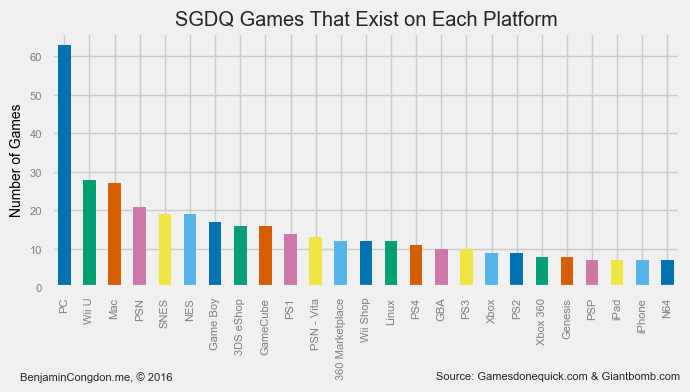

In [4]:
matplotlib.use('agg')

plt.style.use('fivethirtyeight')

plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'normal'

plt.rcParams['xtick.color'] = 'grey'
plt.rcParams['ytick.color'] = 'grey'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['figure.titlesize'] = 12

palette = itertools.cycle(sns.color_palette('colorblind', 25))

platforms = list()
for game in actual_games:
    if 'platforms' in game['data'] and game['data']['platforms']:
        platforms += ([x['name'] for x in game['data']['platforms']])
platforms = pd.Series(platforms)
figure = plt.figure(figsize=(720/100, 475/100), dpi=100)
ax = platforms.value_counts()[:25].plot(kind='bar', color = [palette.next() for x in range(25)])
shortnames = ['PC', 'Wii U', 'Mac', 'PSN', 'SNES' ,'NES', 'Game Boy', '3DS eShop', 'GameCube',
             'PS1', 'PSN - Vita', '360 Marketplace', 'Wii Shop', 'Linux', 'PS4', 'GBA', 'PS3',
              'Xbox', 'PS2', 'Xbox 360', 'Genesis', 'PSP', 'iPad', 'iPhone', 'N64'] 
ax.set_xticklabels(shortnames)

for x in range(25):
    ax.get_xticklabels()[x].title = shortnames
plt.ylabel('Number of Games')
plt.title("{} Games That Exist on Each Platform".format(EVENT_SHORTHAND))
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
add_info(ax, 1, -.35, -.05, -.35)
save_renders('general_platform_counts')

## Release Year Histogram


Earliest Release
title                Marble Madness
duration            0 days 00:05:00
runner                      Elipsis
platform                        NES
release_date    1984-12-15 00:00:00
Name: 60, dtype: object

Latest Release
title                 Hollow Knight
duration            0 days 00:55:00
runner                      Ourolen
platform                         PC
release_date    2017-02-24 00:00:00
Name: 41, dtype: object

Min Duration
title                Marble Madness
duration            0 days 00:05:00
runner                      Elipsis
platform                        NES
release_date    1984-12-15 00:00:00
Name: 60, dtype: object

Max Duration
title             Final Fantasy VII
duration            0 days 08:00:00
runner                     ajneb174
platform                         PC
release_date    1997-01-31 00:00:00
Name: 120, dtype: object


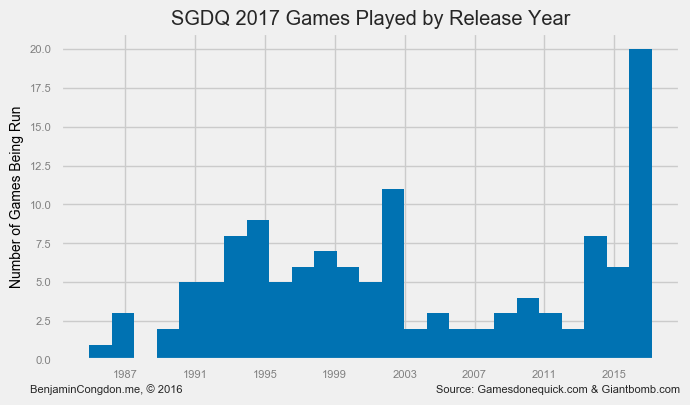

In [5]:

actual_games[0]['data']
game_frame = pd.DataFrame()

game_frame['title'] = [x['title'] for x in actual_games]
game_frame['duration'] = [str(x['duration']) for x in actual_games]
game_frame['runner'] = [x['runner'] for x in actual_games]
game_frame['platform'] = [x['platform'] for x in actual_games]
game_frame['release_date'] = [x['data']['original_release_date'] if 'original_release_date' 
                           in x['data'] else None for x in actual_games]
game_frame['release_date'] = pd.to_datetime(game_frame['release_date'])
game_frame['duration'] = pd.to_timedelta(game_frame['duration'])

print "\nEarliest Release"
print game_frame.ix[game_frame['release_date'].idxmin()]
print "\nLatest Release"
print game_frame.ix[game_frame['release_date'].idxmax()]

print "\nMin Duration"
print game_frame.ix[game_frame['duration'].idxmin()]
print "\nMax Duration"
print game_frame.ix[game_frame['duration'].idxmax()]

figure, ax = plt.subplots(figsize=(720/100, 475/100), dpi=100)
game_frame['release_date'].hist(bins=25, ax=ax, color=sns.color_palette('colorblind', 25)[0])
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.title('{} {} Games Played by Release Year'.format(EVENT_SHORTHAND, EVENT_YEAR))
plt.ylabel('Number of Games Being Run')
add_info(ax, 1, -0.09, -.05, -0.09)
save_renders('num_games_by_year')

## Release Year vs. Playtime

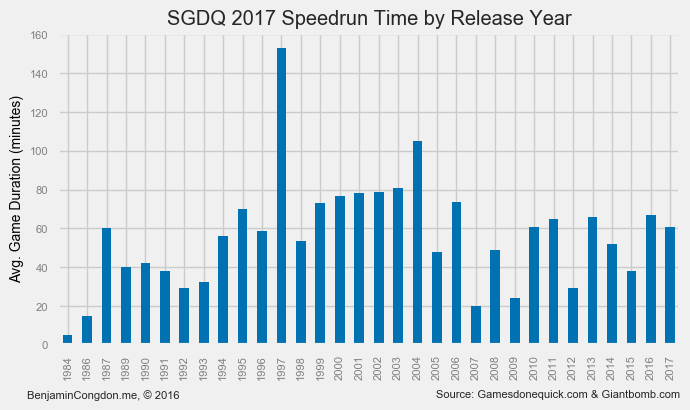

In [6]:
duration_grouped = game_frame.groupby(lambda x: game_frame.ix[x]['release_date'].year)
duration_by_year = duration_grouped.aggregate(np.sum)['duration'].astype('timedelta64[m]')
mean_duration_by_year = duration_by_year / duration_grouped.count()['duration']
figure = plt.figure(figsize=(720/100, 475/100), dpi=100)
ax = mean_duration_by_year.plot(kind='bar', color = sns.color_palette('colorblind', 25)[0])
xtl = [item.get_text()[:4] for item in ax.get_xticklabels()]
_=ax.set_xticklabels(xtl)
plt.ylabel("Avg. Game Duration (minutes)")
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

add_info(ax, 1, -0.16, -.05, -0.16)

plt.title("{} {} Speedrun Time by Release Year".format(EVENT_SHORTHAND, EVENT_YEAR))
save_renders('time_by_release_date')

## Speed Run Scatter

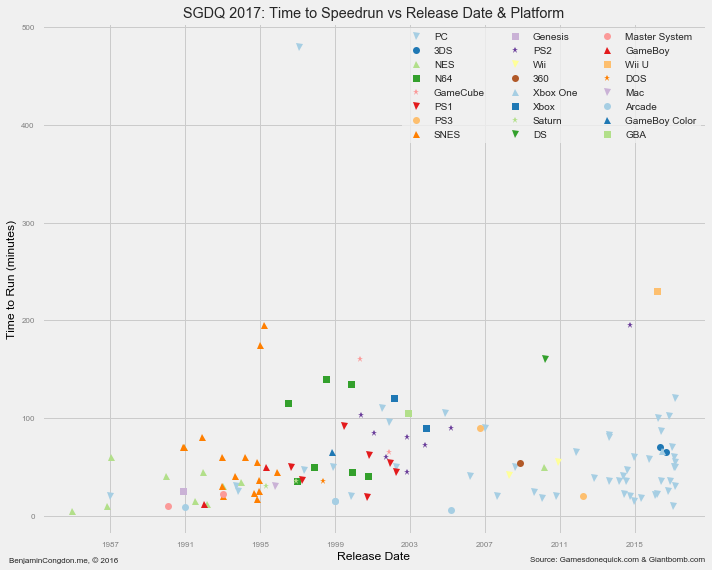

In [7]:
game_frame['minutes'] = game_frame['duration'].astype('timedelta64[m]')
game_frame_corrected = game_frame[pd.notnull(game_frame['release_date'])]
game_frame_corrected = game_frame_corrected.reset_index()
import itertools

platforms = game_frame_corrected['platform'].unique()
palette = itertools.cycle(sns.color_palette('Paired', 21))
color_dict = dict()
for p in platforms:
    color_dict[p] = palette.next()
def map_platform(platform):
    if platform in color_dict:
        return color_dict[platform]
    else:
        return "r"
    
mapped_platforms = list(map_platform(x) for x in game_frame_corrected['platform'])


markers = itertools.cycle(['v', 'o', '^', 's', '*'])

fig, ax = plt.subplots(figsize=(10,8))

for platform in platforms:
    plt_series = game_frame_corrected[game_frame_corrected['platform'] == platform]
    ax.plot_date(x=plt_series.release_date, y=plt_series.minutes,
                  color=map_platform(platform),
                  label=platform, marker=markers.next(), linewidth=1)
plt.xlabel("Release Date", fontsize=12)
plt.ylabel("Time to Run (minutes)", fontsize=12)
legend = ax.legend(loc="upper right", frameon = True, ncol=3)
legend.get_frame().set_linewidth(0)
legend.get_frame().set_facecolor("#F0F0F0")
plt.title("{} {}: Time to Speedrun vs Release Date & Platform".format(EVENT_SHORTHAND, EVENT_YEAR))
add_info(ax, 1, -0.05, -.05, -0.05)
save_renders('running_time_v_release_date')

## Actual Platform Bar Chart

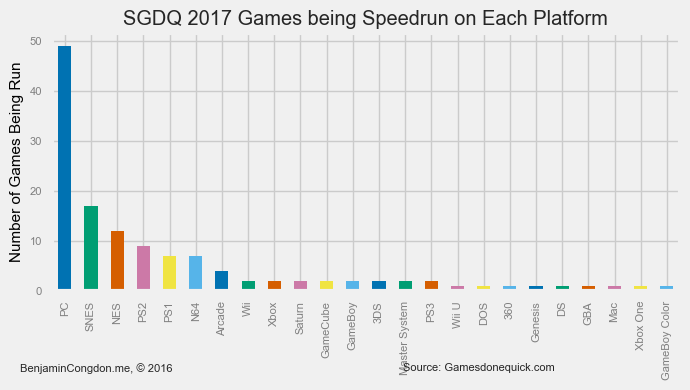

In [8]:
counts = game_frame['platform'].value_counts()
colors_for_graph = [map_platform(x) for x in counts.index]
fig, ax = plt.subplots(figsize=(720/100, 475/100), dpi=100)
ax = game_frame['platform'].value_counts().plot(kind='bar', color = sns.color_palette('colorblind', 25))
plt.ylabel("Number of Games Being Run", fontsize=11)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.text(.8, -0.3,'Source: Gamesdonequick.com',
     horizontalalignment='right',
     verticalalignment='center',
     transform = ax.transAxes,
     fontsize=8)
ax.text(-.05, -0.3, ATTRIBUTION,
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes,
     fontsize=8)
plt.title("{} {} Games being Speedrun on Each Platform".format(EVENT_SHORTHAND, EVENT_YEAR))
save_renders('platforms_run')

## Running Time Histogram

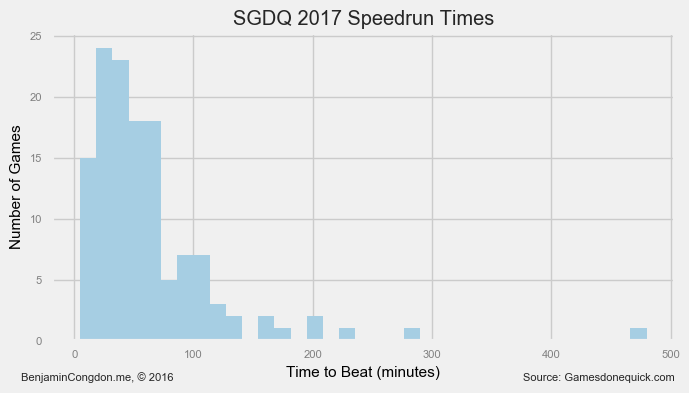

In [9]:
figure = plt.figure(figsize=(720/100, 475/100), dpi=100)

ax = game_frame['minutes'].hist(bins=35, color=colors_for_graph[6])
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel("Time to Beat (minutes)", fontsize=11)
plt.ylabel("Number of Games", fontsize=11)
plt.title("{} {} Speedrun Times".format(EVENT_SHORTHAND, EVENT_YEAR))
add_info(ax, 1, -0.12, -.05, -0.12, 'Source: Gamesdonequick.com')
save_renders('time_to_run_histogram')

## Genres

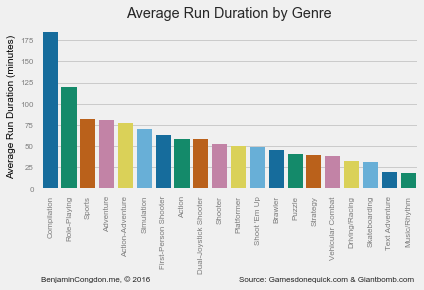

In [10]:
# Add genres to actual_games dicts
all_genres = []
for i in range(len(actual_games)):
    genres = []
    if 'genres' in actual_games[i]['data'] and actual_games[i]['data']['genres']:
        for g in actual_games[i]['data']['genres']:
            genres.append(g['name'])
            if g['name'] not in all_genres:
                all_genres.append(g['name'])
    actual_games[i]['genres'] = ','.join(genres)
games_df = pd.DataFrame(actual_games)
games_df.duration = pd.to_timedelta(games_df['duration'].apply(str))
genre_runtimes = {}
for g in all_genres:
    genre_runtimes[g] = games_df[games_df.genres.str.contains(g)].duration.astype('timedelta64[m]').mean()
genre_tuples = sorted(genre_runtimes.items(), key=itemgetter(1))
fig, ax = plt.subplots()
sns.barplot(*zip(*reversed(genre_tuples)),
            palette=sns.color_palette("colorblind"),
            ax=ax)
ax.set_ylabel("Average Run Duration (minutes)")
ax.set_title("Average Run Duration by Genre")
plt.xticks(rotation='vertical')
add_info(ax, .99, -.55, 0, -.55)
save_renders('genre_runtimes')

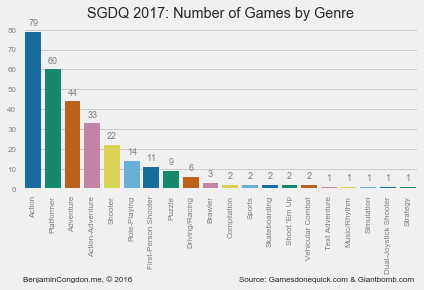

In [11]:
# Genre counts
genre_counts = {}
for g in all_genres:
    genre_counts[g] = len(games_df[games_df.genres.str.contains(g)])
fig, ax = plt.subplots()
genre_count_tuples = sorted(genre_counts.items(), key=itemgetter(1))

sns.barplot(*zip(*reversed(genre_count_tuples)),
            palette=sns.color_palette("colorblind"),
            ax=ax)
ax.set_title("{} {}: Number of Games by Genre".format(EVENT_SHORTHAND, EVENT_YEAR))
plt.xticks(rotation='vertical')
add_info(ax, .99, -.55, 0, -.55)
for p in ax.patches:
    height = p.get_height()
    t = ax.text(p.get_x() + p.get_width() / 2, height+ 3,
                int(height), horizontalalignment='center')
    t.set_color('grey')
    t.set_fontsize(9)
save_renders('genre_counts')